## Context

## Objective

- Explore and visualize the dataset.
- Build clean the data set and missing values.
- Generate a set of insights from the dataset.

### The key question

Do natural disasters worsen the gender-based nutritional disparity among children in Bangladesh?

### Problem Formulation:

We have a regression problem at hand where we will try to run a diff in diff to see if we can find evidence for a gender bais as.

### Proposed approach

Since it is a regression problem we will first start with the parametric model linear regression with a diff-in-diff approache.

### Overall solution design :

The potential solution design would look like this:

- Checking the data description to get the idea of basic statistics or summary of data.
- Univariate analysis to see how data is spread out, getting to know about the outliers.
- Bivariate analysis to see how different attributes vary with the dependent variable.
- Outlier treatment if needed.
- Missing value treatment using appropriate techniques.
- Feature engineering - transforming features, creating new features if possible.
- Choosing the model evaluation technique - 1) R Squared 2) RMSE can be any other metrics related to regression analysis.
- Splitting the data and proceeding with modeling.


### Measures of success :

R-squared.

## Data Dictionary

## Importing the necessary libraries and overview of the dataset

In [1]:
# Importing the basic libraries we will require for the project

# Import libraries for data manipulation
import pandas as pd
import numpy as np
import os
# Import libraries for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization            
import seaborn as sns      

# Import necessary modules
import geopandas as gpd
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

# import module for geoencoding
from geopy.geocoders import Nominatim

# to generate random number
from random import randint

# add sleep time
from time import sleep

import logging

# Set up the color sheme:
import mapclassify as mc


## Functions

In [2]:
# def return_non_na(curr_data,col):
#     return curr_data[col].replace(['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO','Missing'], np.NaN, inplace=True)



def reverse_geocode(geolocator, latlon, sleep_sec):
    """
    This function attempts to perform reverse geocoding using the provided geolocator
    and latitude-longitude coordinates. It handles potential errors and retries on timeouts.

    Args:
        geolocator (object): A geocoding library object used for reverse geocoding.
        latlon (str): A string in the format "latitude,longitude" representing the location.
        sleep_sec (int): The maximum number of seconds to sleep between retries on timeouts.

    Returns:
        object: The result of the reverse geocoding request (may vary depending on the geocoder library).
                - On success, returns the geocoded information.
                - On timeout, retries up to sleep_sec seconds and returns the result.
                - On service error or other exceptions, returns None.
    """

    try:
        # Attempt reverse geocoding using the geolocator in English language
        return geolocator.reverse(latlon, language='en')
    except GeocoderTimedOut:
        # Handle timeout error
        logging.info('TIMED OUT: GeocoderTimedOut: Retrying...')
        # Introduce a random sleep between 1 and sleep_sec seconds to avoid overwhelming the service
        sleep(randint(1 * 100, sleep_sec * 100) / 100)
        # Retry the reverse geocoding with the same parameters
        return reverse_geocode(geolocator, latlon, sleep_sec)
    except GeocoderServiceError as e:
        # Handle service error (e.g., connection refused)
        logging.info('CONNECTION REFUSED: GeocoderServiceError encountered.')
        logging.error(e)  # Log the detailed error for debugging
        return None  # Indicate failure
    except Exception as e:
        # Handle unexpected exceptions
        logging.info('ERROR: Terminating due to exception {}'.format(e))
        return None  # Indicate failure
    

def get_local_information(curr_data, sleep_sec):
    """
    This function enriches a DataFrame with local address information based on latitude and longitude data.

    Args:
        curr_data (pandas.DataFrame): A DataFrame with columns 'LATNUM' and 'LONGNUM' containing latitude and longitude values.
        sleep_sec (int): Number of seconds to sleep between retries for error handling.

    Returns:
        pandas.DataFrame: The DataFrame with additional columns for city, village, county, state_district, state, and country.
        """

    # Initialize the Nominatim geocoder with a user agent string (important for API usage guidelines)
    user_agent = 'bibouPaultest_{}'.format(randint(10000, 99999)) + '@gmail.com'
    geolocator = Nominatim(user_agent=user_agent)

    # Iterate through each row of the DataFrame
    for curr_line in range(curr_data.index.max() + 1):

        # Extract latitude and longitude values for the current row
        Latitude = str(curr_data.loc[curr_line, "LATNUM"])
        Longitude = str(curr_data.loc[curr_line, "LONGNUM"])

        # Perform reverse geocoding to get address information
        location = reverse_geocode(geolocator, Latitude + "," + Longitude, sleep_sec)  # Uses a custom function for retries

        # Extract relevant address components from the geocoding result
        if location:
            address = location.raw['address']
            city = address.get('city')
            village = address.get('village')
            county = address.get('county')
            state_district = address.get('state_district')
            state = address.get('state')
            country = address.get('country')

        # Update the DataFrame with the extracted address information
            curr_data.loc[curr_line, 'city'] = city
            curr_data.loc[curr_line, 'village'] = village
            curr_data.loc[curr_line, 'county'] = county
            curr_data.loc[curr_line, 'state_district'] = state_district
            curr_data.loc[curr_line, 'state'] = state
            curr_data.loc[curr_line, 'country'] = country

        else:
            # Update the DataFrame with the extracted address information
            curr_data.loc[curr_line, 'city'] = np.NAN
            curr_data.loc[curr_line, 'village'] = np.NAN
            curr_data.loc[curr_line, 'county'] = np.NAN
            curr_data.loc[curr_line, 'state_district'] = np.NAN
            curr_data.loc[curr_line, 'state'] = np.NAN
            curr_data.loc[curr_line, 'country'] = np.NAN
    
    # Return the DataFrame with the added address information
    return curr_data

## Loading the data

In [3]:
# Importing the datasets

df = pd.read_stata(os.getcwd() + '\\input\\individual_data\\dat\\idhs_00021.dta') 


# Read file using gpd.read_file()
shp_1999 = gpd.read_file(os.getcwd() + '\\input\\shapefile_data\\shapefile_zip\\BD_1999-00_DHS_03252024_1553_182021\\BDGE42FL\\BDGE42FL.shp')
shp_2004 = gpd.read_file(os.getcwd() + '\\input\\shapefile_data\\shapefile_zip\\BD_2004_DHS_03252024_1554_182021\\BDGE4JFL\\BDGE4JFL.shp')
shp_2007 = gpd.read_file(os.getcwd() + '\\input\\shapefile_data\\shapefile_zip\\BD_2007_DHS_03252024_1554_182021\\BDGE52FL\\BDGE52FL.shp')
shp_2011 = gpd.read_file(os.getcwd() + '\\input\\shapefile_data\\shapefile_zip\\BD_2011_DHS_03252024_1554_182021\\BDGE61FL\\BDGE61FL.shp')
shp_2014 = gpd.read_file(os.getcwd() + '\\input\\shapefile_data\\shapefile_zip\\BD_2014_DHS_03252024_1554_182021\\BDGE71FL\\BDGE71FL.shp')
shp_2017 = gpd.read_file(os.getcwd() + '\\input\\shapefile_data\\shapefile_zip\\BD_2017-18_DHS_03252024_1554_182021\\BDGE7SFL\\BDGE7SFL.shp')

# Importing the bangladesh raw map
bgd_adm = gpd.read_file(os.getcwd() + '\\input\\shapefile_data\\shapefile_zip\\BGD_adm\\BGD_adm2.shp')

# Importing crosswalk
crosswalk = pd.read_excel(os.getcwd() + '\\input\\crosswalk_table.xlsx', dtype={
    'Name_shp': 'string',
    'Name_admin': 'string',
    'Source': 'string'
})



# Importing damaged data
housing_dmg = pd.read_excel(os.getcwd() + '\\input\\disaster_data\\housing damages sidr.xlsx', sheet_name= 'Housing damages', dtype={
    'District': 'string',
    'District corrected': 'string',
    'ID_adm': 'string',
    'District Total Population 2007 est.': 'int64',
    'Total Households': 'int64',
    'Total Vulnerable Households': 'int64',
    'Fully Damaged Households': 'int64',
    'Partially Damaged Households': 'int64',
    'Fully Damaged Vulnerable Households': 'int64',
    'Partially Damaged Vulnerable Households': 'int64',
    'Fully Damaged Non vulnerable Households': 'int64',
    'Partially Damaged Non Vulnerable Households': 'int64'
})



housing_dmg_2 = pd.read_excel(os.getcwd() + '\\input\\disaster_data\\housing damages sidr.xlsx', sheet_name= 'Total damages', dtype={
    "Name of District defaut" : 'string',
    "District corrected" : 'string',
    'ID_adm': 'string',
    "District Total Population 2007 est.": 'int64',
    "No. of Affected Upazila": 'int64',
    "No. of Affected Union": 'int64',
    "No. of Affected Family": 'int64',
    "No. of Affected People": 'int64',
    "Damaged Crops (Acre) Full": 'int64',
    "Damaged Crops (Acre)  Partial": 'int64',
    "Damaged Households Full": 'int64',
    "Damaged Households  Partial": 'int64',
    "No. of death": 'int64',
    "No. of injured people": 'int64',
    "No. of missing people": 'int64',
    "No. of livestock death": 'int64',
    "Affected Educational Institute Full": 'int64',
    "Affected Educational Institute Partial": 'int64',
    "Damaged Road(km) Full": 'int64',
    "Damaged Road(km)  Partial": 'int64',
    "Damaged Bridge/Culvert": 'int64',
    "Damaged Embankment (km)": 'int64',
    "Damaged Trees": 'int64'

})

In [4]:
# Remove the data from the 2017 DHS as the shapefiles are not variables
df = df[df["YEAR"]!=1997]
# 
df["born_after"] = np.where(df['YEAR']>=2011,1,0)
df["born_after"] = df["born_after"].astype("category")

In [5]:
# See variables in the dataset
df.shape

# Convert entire data frame as markdown and print
#print(df.to_markdown())

(36529, 57)


## Check the data types of the columns for the dataset

In [6]:
# Checking info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36529 entries, 6189 to 42717
Data columns (total 57 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SAMPLE           36529 non-null  category
 1   SAMPLESTR        36529 non-null  category
 2   COUNTRY          36529 non-null  category
 3   YEAR             36529 non-null  int32   
 4   IDHSPID          36529 non-null  object  
 5   IDHSHID          36529 non-null  object  
 6   DHSID            36529 non-null  object  
 7   IDHSPSU          36529 non-null  float64 
 8   IDHSSTRATA       36529 non-null  float64 
 9   CASEID           36529 non-null  object  
 10  HHID             36529 non-null  object  
 11  PSU              36529 non-null  float64 
 12  STRATA           36529 non-null  float64 
 13  DOMAIN           36529 non-null  float64 
 14  HHNUM            36529 non-null  float64 
 15  CLUSTERNO        36529 non-null  float64 
 16  LINENO           36529 non-null  int32   


**Observations**:

Let's check the unique values in each column

In [7]:
# Checking unique values in each column
df.nunique()

SAMPLE                 5
SAMPLESTR              5
COUNTRY                1
YEAR                   5
IDHSPID            29666
IDHSHID            27852
DHSID               2263
IDHSPSU             2263
IDHSSTRATA           565
CASEID             27995
HHID               24612
PSU                  600
STRATA               179
DOMAIN                23
HHNUM                465
CLUSTERNO            600
LINENO                25
BIDX                   5
PERWEIGHT           1641
KIDWT               4003
AWFACTT               53
AWFACTU               89
AWFACTR              177
AWFACTE              128
AWFACTW              123
DVWEIGHT             598
URBAN                  2
GEO_BD1994_2014        5
GEO_BD1997             0
GEO_BD2000             6
GEO_BD2004             6
GEO_BD2007             6
GEO_BD2011             7
GEO_BD2014             7
AGE                   37
AGE5YEAR               9
RESIDENT               2
RELIGION               6
MARSTAT                5
CHEB                  15


In [8]:
df[['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO']]

df['HWHAZWHO'].unique()

[-223, -191, 'Flagged cases', 'Height out of plausible limits', 'NIU (not in universe)', ..., 403, -518, 328, 380, 245]
Length: 947
Categories (965, object): [-600 < -599 < -598 < -597 ... 'Age in days out of plausible limits' < 'Flagged cases' < 'Missing' < 'NIU (not in universe)']

In [9]:
df[(df['HWHAZWHO'] == 'Missing') | (df['HWWAZWHO'] == 'Missing') | (df['HWWHZWHO'] == 'Missing')| (df['HWBMIZWHO'] == 'Missing')]
len(df[(df['HWHAZWHO'] == 'Missing') | (df['HWWAZWHO'] == 'Missing') | (df['HWWHZWHO'] == 'Missing')| (df['HWBMIZWHO'] == 'Missing')])

2244

In [10]:

df.KIDSEX.value_counts(normalize=True)
# # return_non_na
# # df.replace('Missing', np.NaN, inplace=True)

# map(return_non_na, df, lst_outcomes)


KIDSEX
Male      0.511867
Female    0.488133
Name: proportion, dtype: float64

In [11]:
lst_outcomes=['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO']
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: x.replace(['Age in days out of plausible limits','Flagged cases','Missing','NIU (not in universe)'], np.NaN))
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: pd.to_numeric(x, errors='coerce'))


C:\Users\ASUS\AppData\Local\Temp\ipykernel_20172\3933648467.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[lst_outcomes] = df[lst_outcomes].apply(lambda x: x.replace(['Age in days out of plausible limits','Flagged cases','Missing','NIU (not in universe)'], np.NaN))


In [12]:
lst_depvar=['KIDAGEMO', 'KIDSEX']
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: x.replace(['Age in days out of plausible limits','Flagged cases','Missing','NIU (not in universe)'], np.NaN))
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [13]:
df = df.assign(**{col: df[col] / 100 for col in lst_outcomes})


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,36529.0,2.007593e+03,4.992744e+00,2.000000e+03,2.004000e+03,2.007000e+03,2.011000e+03,2.014000e+03
IDHSPSU,36529.0,5.005108e+09,1.424356e+06,5.003000e+09,5.004000e+09,5.005000e+09,5.006001e+09,5.007001e+09
IDHSSTRATA,36529.0,5.005109e+08,1.424009e+05,5.003000e+08,5.004001e+08,5.005001e+08,5.006000e+08,5.007000e+08
PSU,36529.0,2.586824e+02,1.674505e+02,1.000000e+00,1.160000e+02,2.320000e+02,3.930000e+02,6.000000e+02
STRATA,36529.0,5.504279e+01,5.331771e+01,1.000000e+00,1.500000e+01,2.100000e+01,9.800000e+01,1.790000e+02
DOMAIN,36529.0,9.702182e+00,7.195199e+00,0.000000e+00,3.000000e+00,1.000000e+01,1.600000e+01,2.200000e+01
HHNUM,36529.0,7.425905e+01,6.913679e+01,1.000000e+00,2.800000e+01,5.900000e+01,9.500000e+01,5.330000e+02
CLUSTERNO,36529.0,2.586824e+02,1.674505e+02,1.000000e+00,1.160000e+02,2.320000e+02,3.930000e+02,6.000000e+02
LINENO,36529.0,2.904596e+00,2.040628e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.700000e+01
BIDX,36529.0,1.203154e+00,4.406707e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00


In [15]:
print(df.head().to_markdown())

|      | SAMPLE             |   SAMPLESTR | COUNTRY    |   YEAR | IDHSPID             | IDHSHID          | DHSID          |   IDHSPSU |   IDHSSTRATA | CASEID   | HHID   |   PSU |   STRATA |   DOMAIN |   HHNUM |   CLUSTERNO |   LINENO |   BIDX |   PERWEIGHT |   KIDWT |   AWFACTT |   AWFACTU |   AWFACTR |   AWFACTE |   AWFACTW |   DVWEIGHT | URBAN   | GEO_BD1994_2014      |   GEO_BD1997 | GEO_BD2000   |   GEO_BD2004 |   GEO_BD2007 |   GEO_BD2011 |   GEO_BD2014 |   AGE | AGE5YEAR   | RESIDENT       | RELIGION   | MARSTAT   |   CHEB | CURRWORK   | WEALTHQ   |   WEALTHS | EDUCLVL   |   EDYRTOTAL | KIDSEX   |   LINENOKID | KIDAGEMO              | HWWEIGHT              | HWHEIGHT              | HWWHYNOTMEAS   | HWDAYOFBIRTH          |   HWHAZWHO |   HWWAZWHO |   HWWHZWHO |   HWBMIZWHO |   born_after |
|-----:|:-------------------|------------:|:-----------|-------:|:--------------------|:-----------------|:---------------|----------:|-------------:|:---------|:-------|------:|---------:|-----

In [16]:
df['YEAR'] = df['YEAR'].astype("category")

In [17]:

# duplication
df[df.duplicated()]

,SAMPLE,SAMPLESTR,COUNTRY,YEAR,IDHSPID,IDHSHID,DHSID,IDHSPSU,IDHSSTRATA,CASEID,...,KIDAGEMO,HWWEIGHT,HWHEIGHT,HWWHYNOTMEAS,HWDAYOFBIRTH,HWHAZWHO,HWWAZWHO,HWWHZWHO,HWBMIZWHO,born_after


**Observations**:
No duplicate observations.

## Exploratory Data Analysis

Now that we have an understanding of the business problem we want to solve, and we have loaded the datasets, the next step to follow is to have a better understanding of the dataset, i.e., what is the distribution of the variables, what are different relationships that exist between variables, etc. If there are any data anomalies like missing values or outliers, how do we treat them to prepare the dataset for building the model?

Let's check the percentage of missing values using the below code.

In [18]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df.isna().sum()/df.isna().count()*100,2),'Nbr of Missing Values':df.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
GEO_BD1997,100.00,36529
DVWEIGHT,83.16,30379
GEO_BD2007,83.16,30379
GEO_BD2000,81.30,29697
GEO_BD2004,81.09,29621
GEO_BD2014,78.41,28643
GEO_BD2011,76.04,27776
AWFACTW,18.70,6832
LINENOKID,18.70,6832
HWWAZWHO,14.59,5329


In [19]:

#outcome variable 
outcomes_cols = ['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO']



In [20]:
#Summarize data
df.describe().T

df.columns

Index(['SAMPLE', 'SAMPLESTR', 'COUNTRY', 'YEAR', 'IDHSPID', 'IDHSHID', 'DHSID',
       'IDHSPSU', 'IDHSSTRATA', 'CASEID', 'HHID', 'PSU', 'STRATA', 'DOMAIN',
       'HHNUM', 'CLUSTERNO', 'LINENO', 'BIDX', 'PERWEIGHT', 'KIDWT', 'AWFACTT',
       'AWFACTU', 'AWFACTR', 'AWFACTE', 'AWFACTW', 'DVWEIGHT', 'URBAN',
       'GEO_BD1994_2014', 'GEO_BD1997', 'GEO_BD2000', 'GEO_BD2004',
       'GEO_BD2007', 'GEO_BD2011', 'GEO_BD2014', 'AGE', 'AGE5YEAR', 'RESIDENT',
       'RELIGION', 'MARSTAT', 'CHEB', 'CURRWORK', 'WEALTHQ', 'WEALTHS',
       'EDUCLVL', 'EDYRTOTAL', 'KIDSEX', 'LINENOKID', 'KIDAGEMO', 'HWWEIGHT',
       'HWHEIGHT', 'HWWHYNOTMEAS', 'HWDAYOFBIRTH', 'HWHAZWHO', 'HWWAZWHO',
       'HWWHZWHO', 'HWBMIZWHO', 'born_after'],
      dtype='object')

In [21]:
df.YEAR.value_counts(normalize=True)

YEAR
2011    0.239618
2014    0.215883
2004    0.189110
2000    0.187029
2007    0.168359
Name: proportion, dtype: float64

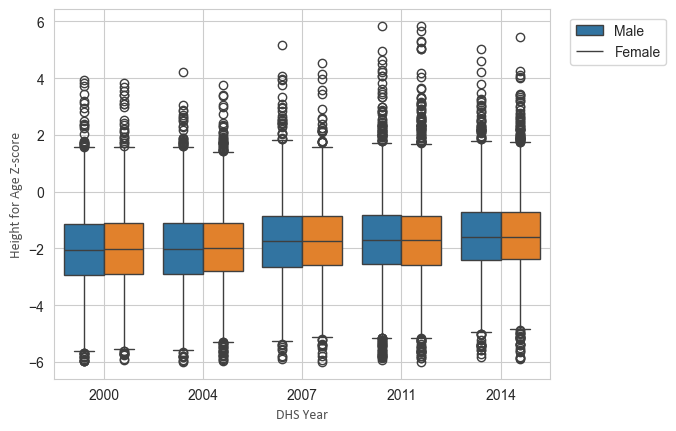

<Figure size 640x480 with 0 Axes>

In [22]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

g1 = sns.boxplot(data=df, x="YEAR", y="HWHAZWHO", hue="KIDSEX")

g1.set_xlabel("DHS Year", fontsize=10, color=font_color, **hfont)
g1.set_ylabel("Height for Age Z-score", fontsize=10, color=font_color, **hfont)



#title = 'Average Foreign Exchange Rates, 2000–2019'
#fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
#subtitle = 'Source: Author own calculation'
#plt.title(subtitle, fontsize=18, pad=10, color=font_color, **hfont)
#plt.subplots_adjust(top=0.85)

# title
#new_title = ''
#g1.legend.set_title(new_title)
# replace labels
# new_labels = ['Urban 555', 'Rural']
# for t, l in zip(g1.texts, new_labels):
#     t.set_text(l)
plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Height for Age Z-score dist'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

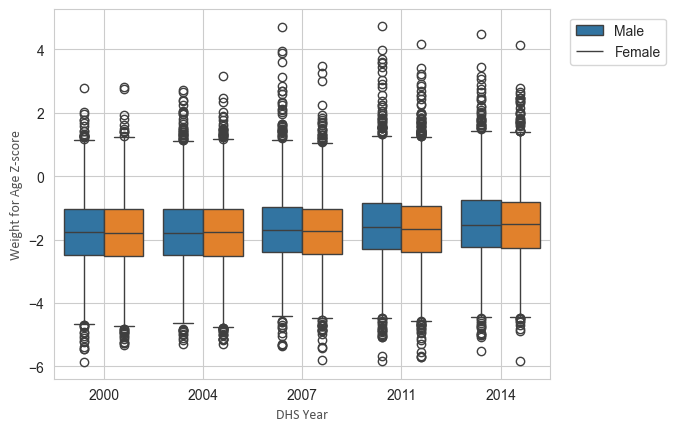

<Figure size 640x480 with 0 Axes>

In [23]:
g2 = sns.boxplot(data=df, x="YEAR", y="HWWAZWHO", hue="KIDSEX")

g2.set_xlabel("DHS Year", fontsize=10, color=font_color, **hfont)
g2.set_ylabel("Weight for Age Z-score", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Weight for Age Z-score dist'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

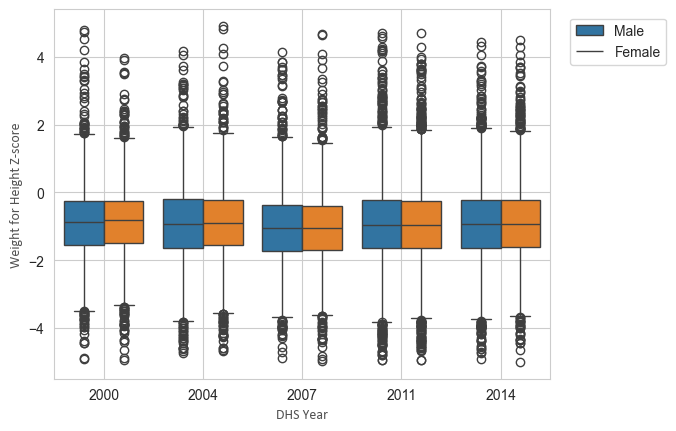

<Figure size 640x480 with 0 Axes>

In [24]:
g3 = sns.boxplot(data=df, x="YEAR", y="HWWHZWHO", hue="KIDSEX")
g3.set_xlabel("DHS Year", fontsize=10, color=font_color, **hfont)
g3.set_ylabel("Weight for Height Z-score", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Weight for Height Z-score dist'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

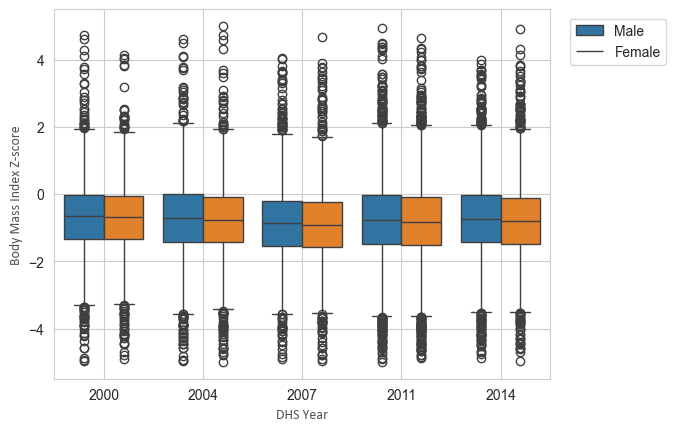

<Figure size 640x480 with 0 Axes>

In [25]:
g4 = sns.boxplot(data=df, x="YEAR", y="HWBMIZWHO", hue="KIDSEX")
g4.set_xlabel("DHS Year", fontsize=10, color=font_color, **hfont)
g4.set_ylabel("Body Mass Index Z-score", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Body Mass Index Z-score dist'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

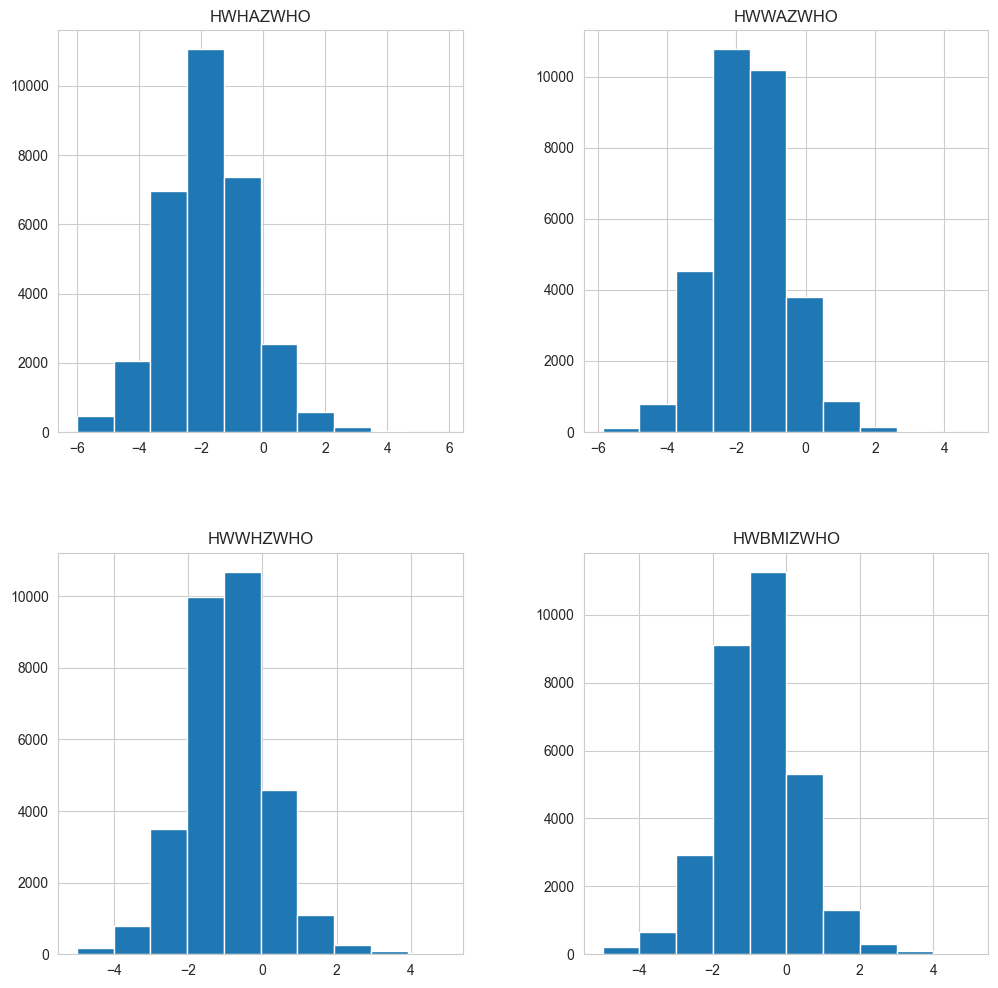

In [26]:
#title=['Height for Age Z-score','Weight for Age Z-score','Weight for Height Z-score','Body Mass Index Z-score']
df[['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO']].hist(figsize=(12,12))

#plt.title(title, fontsize=18, pad=10, color=font_color, **hfont)
plt.show()

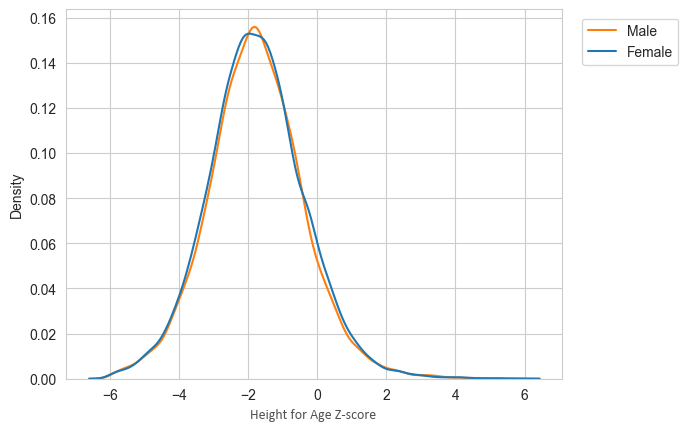

<Figure size 640x480 with 0 Axes>

In [27]:
g5 = sns.kdeplot(data=df, x="HWHAZWHO", hue="KIDSEX")
g5.set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Body Mass Index Z-score dist'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

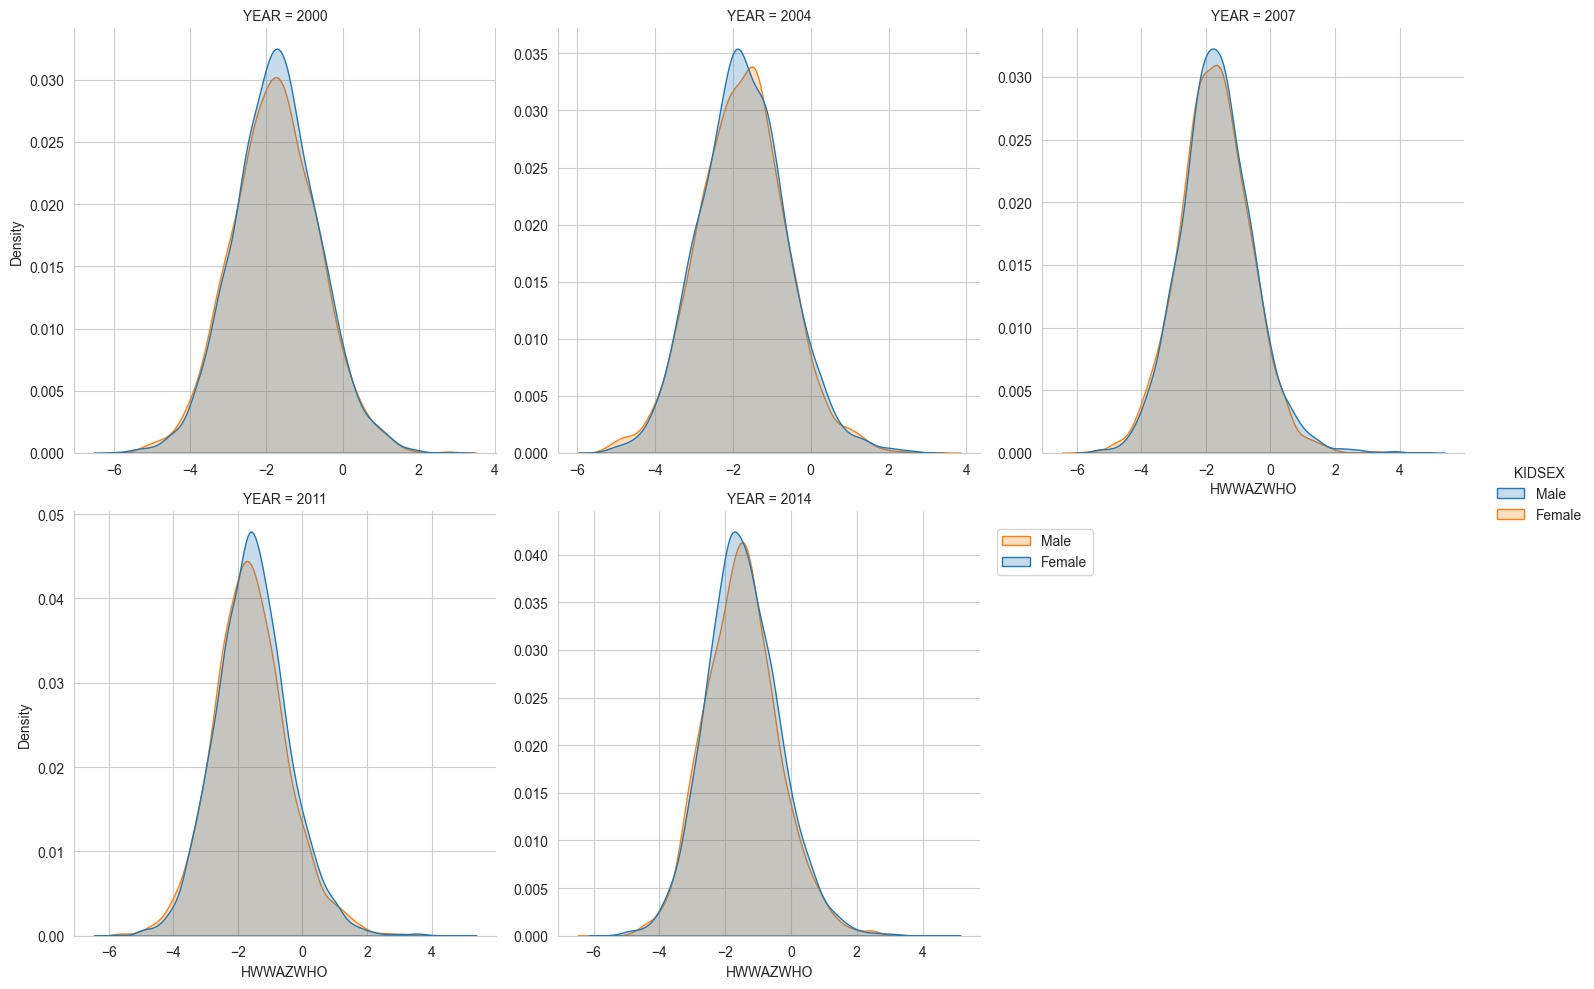

In [28]:
#g10 = sns.FacetGrid(data=df, col='YEAR', hue='KIDSEX', col_wrap=3)

#g10.map(sns.kdeplot, x="HWWAZWHO", cut=0, fill=True,  alpha=1,  clip=(-5, 5))
# g5.set_xlabel("Weight for Age Z-score", fontsize=10, color=font_color, **hfont)


# plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
# plt.grid(True)
# plt.show()

g5 = sns.displot(data=df, col='YEAR', hue='KIDSEX', x='HWWAZWHO', kind='kde', col_wrap=3,fill=True, facet_kws={'sharey': False, 'sharex': False})
# control the title of each facet
#g5 = g5.set_titles("{col_name}")
#g5.set_xlabel("Weight for Age Z-score", fontsize=10, color=font_color, **hfont)
plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
filename = 'Weight for Age Z-score density'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

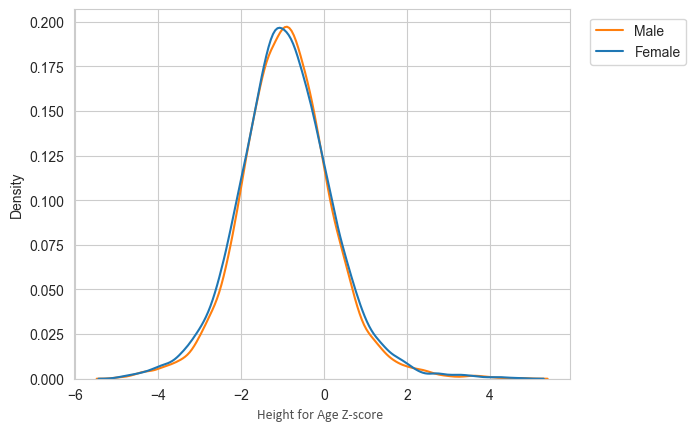

<Figure size 640x480 with 0 Axes>

In [29]:
g5 = sns.kdeplot(data=df, x='HWWHZWHO', hue="KIDSEX")
g5.set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Weight for Height Z-score density'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

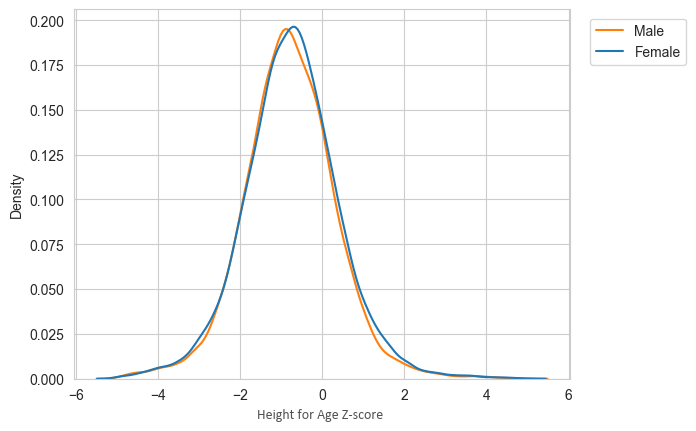

<Figure size 640x480 with 0 Axes>

In [30]:
g5 = sns.kdeplot(data=df, x='HWBMIZWHO', hue="KIDSEX")
g5.set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)


plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'Body Mass Index Z-score density'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

## Spatial data analysis

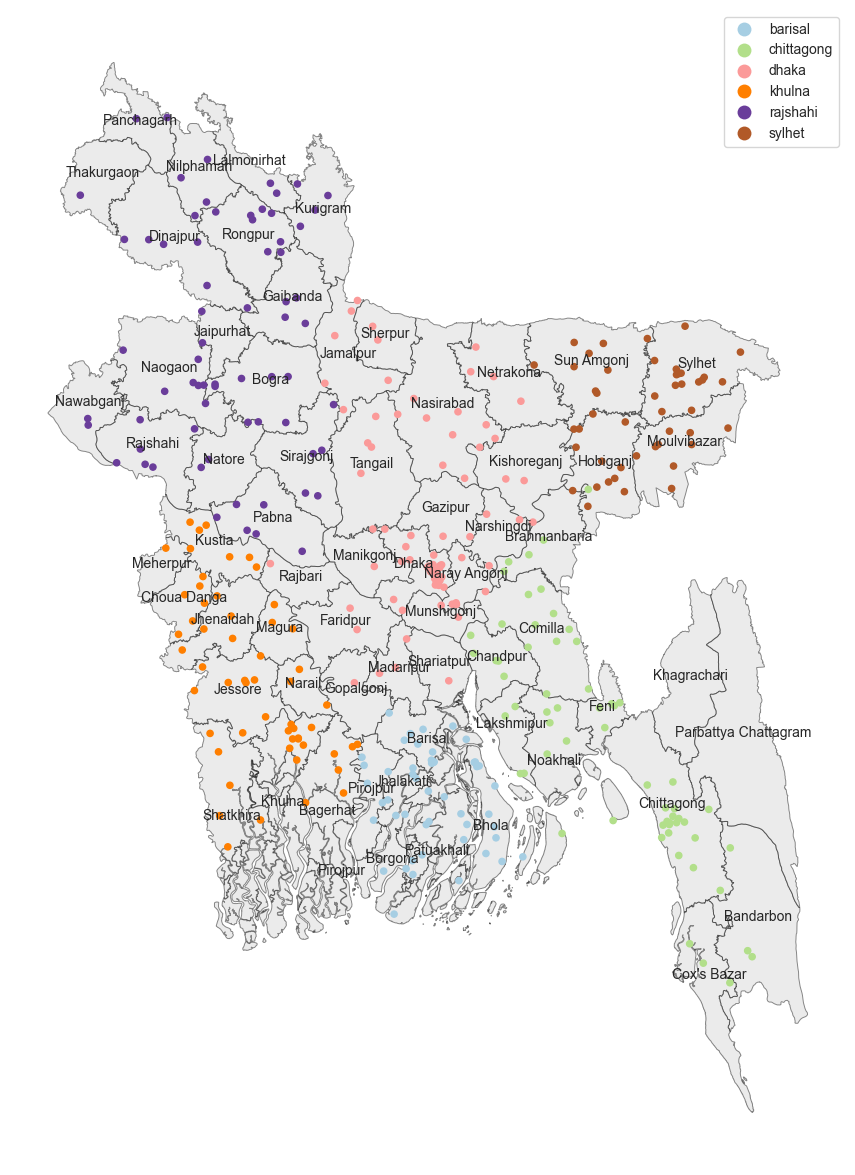

In [31]:
# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(figsize=(15,15))
bgd_adm.apply(lambda x: ax.annotate(text=x['NAME_2'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
bgd_plot=bgd_adm.plot(ax=ax, color='lightgrey', edgecolor='black',lw=0.7, alpha=0.45)

# Sans axe 
ax.axis('off')

# using set_facecolor() method
ax.set_facecolor("red")

# Rajouter le titre
ax.set_title('', fontsize=23)

# Rajouter les coordonnées GPS des points sur la carte
csm = shp_2007.plot(ax=bgd_plot, column='DHSREGNA', cmap='Paired', markersize=20, legend=True)

In [32]:
shp_2004 = shp_2004.drop(shp_2004[(shp_2004['LATNUM']==0) & (shp_2004['LONGNUM']==0)].index, axis=0)
shp_2014 = shp_2014.drop(shp_2014[(shp_2014['LATNUM']==0) & (shp_2014['LONGNUM']==0)].index, axis=0)

# resetting the DataFrame index
shp_2004 = shp_2004.reset_index()
shp_2014 = shp_2014.reset_index()

In [33]:
# building and id for each

#bgd_adm.assign(ID = str(bgd_adm["ID_1"] + bgd_adm["ID_2"]))

bgd_adm["ID"] = bgd_adm["ID_1"].astype("str") + bgd_adm["ID_2"].astype("str")
bgd_adm["ID"] = bgd_adm["ID"].astype("str")


In [90]:
# list of the most exposed district names
housing_dmg = housing_dmg.assign(damaged_hh = housing_dmg["Fully Damaged Households"] / housing_dmg["District Total Population 2007 est."])
# list of the most exposed district names in the list 
housing_dmg_2 = housing_dmg_2.assign(damaged_hh = housing_dmg_2["No. of Affected People"] / housing_dmg_2["District Total Population 2007 est."])
#lst_mst_affctd = housing_dmg[housing_dmg["Fully Damaged Households"] >= housing_dmg["Fully Damaged Households"].quantile(1/5)]["District corrected"].astype("str")


c:\Users\ASUS\Dropbox\PhD thesis\chapitre_2\PhD-Chapter-2\my_venv\Lib\site-packages\mapclassify\classifiers.py:1592: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 5.
  self.bins = quantile(y, k=k)
c:\Users\ASUS\Dropbox\PhD thesis\chapitre_2\PhD-Chapter-2\my_venv\Lib\site-packages\mapclassify\classifiers.py:1592: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 5.
  self.bins = quantile(y, k=k)


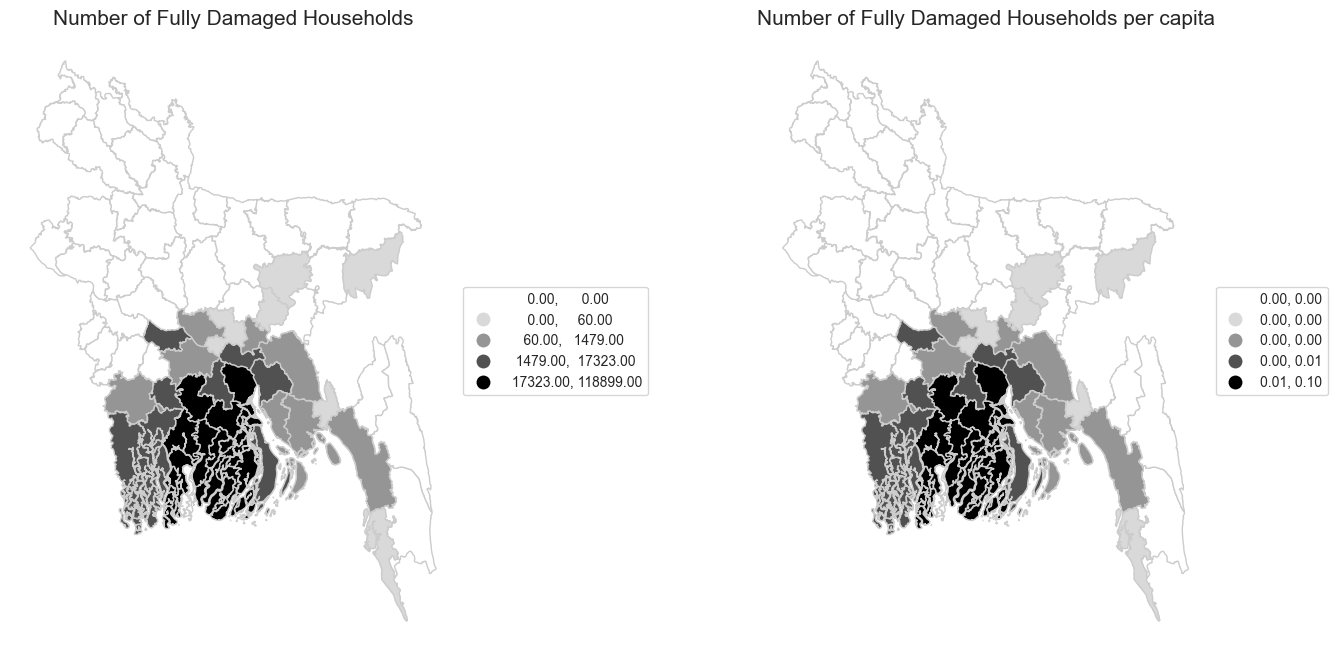

In [99]:
# Explicitly specifying the columns for joining
merged = bgd_adm.merge(housing_dmg, left_on='ID', right_on='ID_adm', how='left')

# Replace na by 0

merged["Fully Damaged Households"] = merged["Fully Damaged Households"].fillna(0)
merged["damaged_hh"] = merged["damaged_hh"].fillna(0)
# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(17.8,8))
cmap = 'Greys'
merged.plot(column="Fully Damaged Households", scheme="quantiles", k=8, cmap=cmap, ax=ax[0], edgecolor='0.8', legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": False})
merged.plot(column="damaged_hh", scheme="quantiles", k=8, cmap=cmap, ax = ax[1], edgecolor='0.8', legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": False})
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Number of Fully Damaged Households', fontdict={'fontsize': '15'})
ax[1].set_title('Number of Fully Damaged Households per capita', fontdict={'fontsize': '15'})
# Create an annotation for the data source
#ax.annotate('Government of Bangladesh Report (2008)',xy=(0, 0))
#,xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='#555555'
# Create colorbar as a legend
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=merged["Fully Damaged Households"].astype("int64").min(), vmax=merged["Fully Damaged Households"].astype("int64").max()))

# Empty array for the data range
#sm._A = []
# Add the colorbar to the figure
#cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
#cbar = fig.colorbar(sm, cax=cbaxes)
filename="fully_damaged_hh"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

c:\Users\ASUS\Dropbox\PhD thesis\chapitre_2\PhD-Chapter-2\my_venv\Lib\site-packages\mapclassify\classifiers.py:1592: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 5.
  self.bins = quantile(y, k=k)
c:\Users\ASUS\Dropbox\PhD thesis\chapitre_2\PhD-Chapter-2\my_venv\Lib\site-packages\mapclassify\classifiers.py:1592: UserWarning: Not enough unique values in array to form 7 classes. Setting k to 5.
  self.bins = quantile(y, k=k)


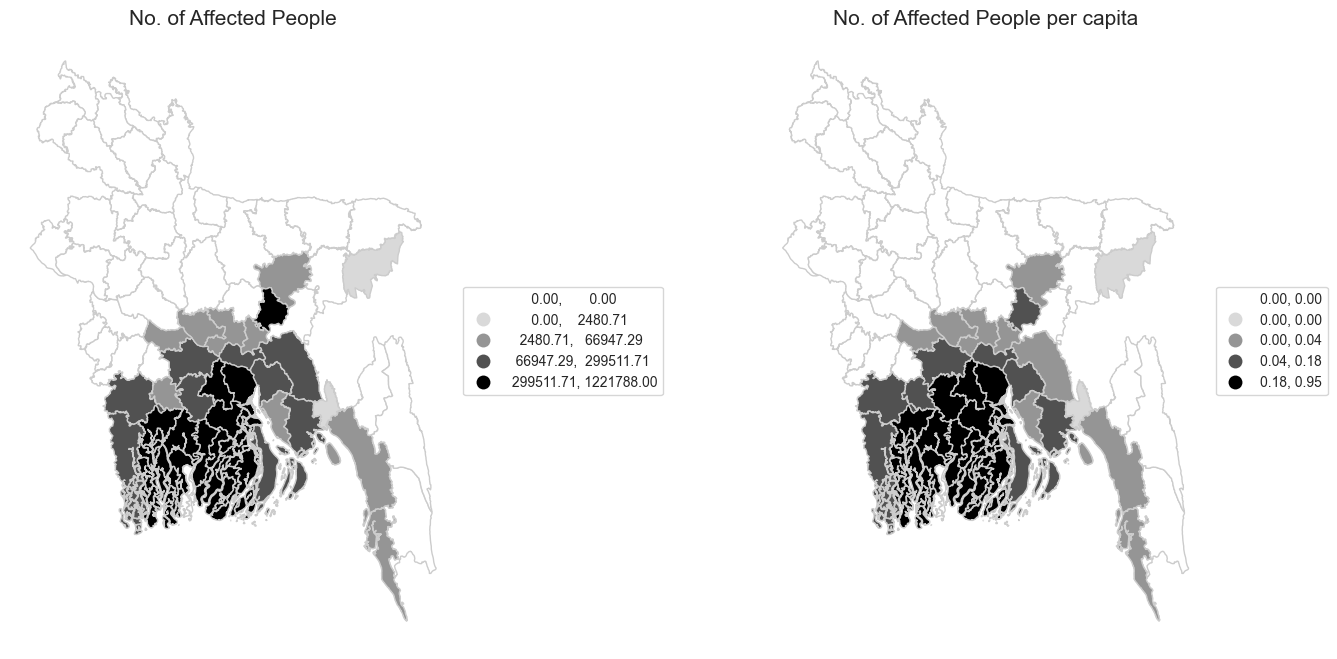

In [103]:
# Explicitly specifying the columns for joining
merged_2 = bgd_adm.merge(housing_dmg_2, left_on='ID', right_on='ID_adm', how='left')

# Replace na by 0
merged_2["No. of Affected People"] = merged_2["No. of Affected People"].fillna(0)
merged_2["damaged_hh"] = merged_2["damaged_hh"].fillna(0)
# Représentation graphique des regions du Bangladesh
# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(17.8,8))
cmap = 'Greys'
merged_2.plot(column="No. of Affected People", scheme="quantiles", k=7, cmap=cmap, ax = ax[0], edgecolor='0.8', legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": False})
merged_2.plot(column="damaged_hh", scheme="quantiles", k=7, cmap=cmap, ax = ax[1], edgecolor='0.8', legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": False})
ax[0].axis('off')
ax[0].set_title('No. of Affected People', fontdict={'fontsize': '15'})
ax[1].axis('off')
ax[1].set_title('No. of Affected People per capita', fontdict={'fontsize': '15'})
# Create an annotation for the data source
#ax.annotate('Ministry of Food and Disaster Management (2007)',xy=(0, 0))

filename="affected_people_hh"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

In [35]:
# import mapclassify as mc
# import geoplot as gplt
# fig, ax = plt.subplots(1, 1, figsize=(16, 12))
# scheme = mc.Quantiles(merged['Fully Damaged Households'], k=6)

# # Map
# gplt.choropleth(merged, 
#     hue="Fully Damaged Households", 
#     linewidth=.1,
#     scheme=scheme, cmap='inferno_r',
#     legend=True,
#     edgecolor='black',
#     ax=ax
# );

# ax.set_title('Unemployment rate in US counties', fontsize=13);

# fig, ax = plt.subplots()
# merged.plot(ax=ax,column='Fully Damaged Households',cmap='OrRd',scheme='quantiles',legend=True,legend_kwds=dict(loc='upper right',bbox_to_anchor=(1.5, .9),fontsize='small',title="Legend",frameon=False))
# ax.axis('off')

In [36]:
#merged.loc[merged.index.get_loc(merged["Fully Damaged Households"].fillna(0).astype("int64").idxmin()) - 1, "Fully Damaged Households"]
merged = merged.sort_values(by="Fully Damaged Households", ascending=True)
merged.iloc[merged.index.get_loc(merged["Fully Damaged Households"].astype("int64").idxmin()) + 1]

merged[merged["District corrected"]=="Narshingdi"]

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,...,ID_adm_2,District Total Population 2007 est.,Total Households,Total Vulnerable Households,Fully Damaged Households,Partially Damaged Households,Fully Damaged Vulnerable Households,Partially Damaged Vulnerable Households,Fully Damaged Non‐ vulnerable Households,Partially Damaged Non‐ Vulnerable Households
27,20,BGD,Bangladesh,3,Dhaka,28,Narshingdi,Zila,District,None,...,328.0,2199341.0,382440.0,19122.0,24.0,5280.0,1.0,264.0,23.0,5016.0


In [37]:
print(bgd_adm.NAME_2.sort_values(ascending=True).to_markdown())

|    | NAME_2               |
|---:|:---------------------|
| 34 | Bagerhat             |
|  6 | Bandarbon            |
|  0 | Barisal              |
|  1 | Bhola                |
| 45 | Bogra                |
|  2 | Borgona              |
|  7 | Brahmanbaria         |
|  8 | Chandpur             |
|  9 | Chittagong           |
| 35 | Choua Danga          |
| 10 | Comilla              |
| 11 | Cox's Bazar          |
| 17 | Dhaka                |
| 53 | Dinajpur             |
| 18 | Faridpur             |
| 12 | Feni                 |
| 54 | Gaibanda             |
| 19 | Gazipur              |
| 20 | Gopalgonj            |
| 61 | Hobiganj             |
| 46 | Jaipurhat            |
| 21 | Jamalpur             |
| 36 | Jessore              |
|  3 | Jhalakati            |
| 37 | Jhenaidah            |
| 13 | Khagrachari          |
| 38 | Khulna               |
| 22 | Kishoreganj          |
| 55 | Kurigram             |
| 39 | Kustia               |
| 14 | Lakshmipur           |
| 56 | Lal

In [38]:
merged.describe().T

,count,mean,std,min,25%,50%,75%,max
ID_0,65.0,2.000000e+01,0.000000e+00,20.0,20.00,20.0,20.00,20.0
ID_1,65.0,3.676923e+00,1.696575e+00,1.0,2.00,3.0,5.00,7.0
ID_2,65.0,3.300000e+01,1.890767e+01,1.0,17.00,33.0,49.00,65.0
ID_adm_2,30.0,2.641000e+02,1.753903e+02,11.0,210.25,320.0,330.25,763.0
District Total Population 2007 est.,30.0,2.436702e+06,1.939569e+06,805308.0,1373499.00,1922985.0,2708348.00,9701012.0
Total Households,30.0,4.134120e+05,3.386602e+05,140020.0,232230.00,308050.0,456260.00,1788520.0
Total Vulnerable Households,30.0,2.067060e+04,1.693301e+04,7001.0,11611.50,15402.5,22813.00,89426.0
Fully Damaged Households,65.0,8.691800e+03,2.302596e+04,0.0,0.00,0.0,1479.00,118899.0
Partially Damaged Households,30.0,3.190367e+04,4.203809e+04,89.0,2730.00,6414.5,63839.50,132369.0
Fully Damaged Vulnerable Households,30.0,9.416667e+02,1.559341e+03,1.0,25.50,160.5,1121.75,5945.0


In [39]:
pd.DataFrame(data={'% of Missing Values':round(merged.isna().sum()/merged.isna().count()*100,2),'Nbr of Missing Values':merged.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
NL_NAME_2,100.00,65
District,53.85,35
District corrected,53.85,35
Fully Damaged Non‐ vulnerable Households,53.85,35
Partially Damaged Vulnerable Households,53.85,35
Fully Damaged Vulnerable Households,53.85,35
Partially Damaged Households,53.85,35
Total Vulnerable Households,53.85,35
Total Households,53.85,35
District Total Population 2007 est.,53.85,35


In [40]:
merged[['District Total Population 2007 est.','Total Households', 'Total Vulnerable Households','Fully Damaged Households', 'Partially Damaged Households','Fully Damaged Vulnerable Households','Partially Damaged Vulnerable Households','Fully Damaged Non‐ vulnerable Households','Partially Damaged Non‐ Vulnerable Households']] = merged[['District Total Population 2007 est.','Total Households', 'Total Vulnerable Households','Fully Damaged Households', 'Partially Damaged Households','Fully Damaged Vulnerable Households','Partially Damaged Vulnerable Households','Fully Damaged Non‐ vulnerable Households','Partially Damaged Non‐ Vulnerable Households']].replace(np.NaN, '0')


In [104]:
merged.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,...,ID_adm_2,District Total Population 2007 est.,Total Households,Total Vulnerable Households,Fully Damaged Households,Partially Damaged Households,Fully Damaged Vulnerable Households,Partially Damaged Vulnerable Households,Fully Damaged Non‐ vulnerable Households,Partially Damaged Non‐ Vulnerable Households
32,20,BGD,Bangladesh,3,Dhaka,33,Sherpur,Zila,District,None,...,NaN,0,0,0,0.0,0,0,0,0,0
63,20,BGD,Bangladesh,7,Sylhet,64,Sun Amgonj,Zila,District,None,...,NaN,0,0,0,0.0,0,0,0,0,0
33,20,BGD,Bangladesh,3,Dhaka,34,Tangail,Zila,District,None,...,NaN,0,0,0,0.0,0,0,0,0,0
35,20,BGD,Bangladesh,4,Khulna,36,Choua Danga,Zila,District,None,...,NaN,0,0,0,0.0,0,0,0,0,0
37,20,BGD,Bangladesh,4,Khulna,38,Jhenaidah,Zila,District,None,...,NaN,0,0,0,0.0,0,0,0,0,0


## Get the city, state, and country names from latitude and longitude using Python

In [42]:
shp_1999["city"]=""
shp_1999["village"]=""
shp_1999["county"]=""
shp_1999["state_district"]=""
shp_1999["state"]=""
shp_1999["country"]=""

shp_2004["city"]=""
shp_2004["village"]=""
shp_2004["county"]=""
shp_2004["state_district"]=""
shp_2004["state"]=""
shp_2004["country"]=""

shp_2007["city"]=""
shp_2007["village"]=""
shp_2007["county"]=""
shp_2007["state_district"]=""
shp_2007["state"]=""
shp_2007["country"]=""

shp_2011["city"]=""
shp_2011["village"]=""
shp_2011["county"]=""
shp_2011["state_district"]=""
shp_2011["state"]=""
shp_2011["country"]=""

shp_2014["city"]=""
shp_2014["village"]=""
shp_2014["county"]=""
shp_2014["state_district"]=""
shp_2014["state"]=""
shp_2014["country"]=""

shp_2017["city"]=""
shp_2017["village"]=""
shp_2017["county"]=""
shp_2017["state_district"]=""
shp_2017["state"]=""
shp_2017["country"]=""


# Create the address columns in a single operation for efficiency
# shp_1999['city', 'village', 'county', 'state_district', 'state', 'country']=['','','','','','']
# shp_2004['city', 'village', 'county', 'state_district', 'state', 'country']=["","","","","",""]
# shp_2007['city', 'village', 'county', 'state_district', 'state', 'country']=["","","","","",""]
# shp_2011['city', 'village', 'county', 'state_district', 'state', 'country']=["","","","","",""]
# shp_2014['city', 'village', 'county', 'state_district', 'state', 'country']=["","","","","",""]
# shp_2017['city', 'village', 'county', 'state_district', 'state', 'country']=["","","","","",""]

In [43]:
# Get district related to each cluster
get_local_information(shp_1999, 10)
get_local_information(shp_2004, 10)
get_local_information(shp_2007, 10)
get_local_information(shp_2011, 10)
get_local_information(shp_2014, 10)
get_local_information(shp_2017, 10)

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,ALT_GPS,ALT_DEM,DATUM,geometry,city,village,county,state_district,state,country
0,BD201800000001,BD,2018.0,1.0,BG,NULL,NULL,NULL,NULL,1.0,...,49.0,7.0,WGS84,POINT (90.10647 21.90745),None,None,Taltali Subdistrict,Barguna District,Barishal Division,Bangladesh
1,BD201800000002,BD,2018.0,2.0,BG,NULL,NULL,NULL,NULL,1.0,...,34.0,10.0,WGS84,POINT (90.29871 22.17195),None,Haldia,Amtali Subdistrict,Barguna District,Barishal Division,Bangladesh
2,BD201800000003,BD,2018.0,3.0,BG,NULL,NULL,NULL,NULL,1.0,...,22.0,6.0,WGS84,POINT (90.18748 22.16715),Barguna,None,Barguna Sadar Subdistrict,Barguna District,Barishal Division,Bangladesh
3,BD201800000004,BD,2018.0,4.0,BG,NULL,NULL,NULL,NULL,1.0,...,4.0,10.0,WGS84,POINT (90.12207 22.19562),None,Khajurtala,Barguna Sadar Subdistrict,Barguna District,Barishal Division,Bangladesh
4,BD201800000005,BD,2018.0,5.0,BG,NULL,NULL,NULL,NULL,1.0,...,54.0,9.0,WGS84,POINT (90.17927 22.34890),None,None,Betagi Subdistrict,Barguna District,Barishal Division,Bangladesh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,BD201800000671,BD,2018.0,671.0,BG,NULL,NULL,NULL,NULL,8.0,...,42.0,22.0,WGS84,POINT (91.87764 24.88692),Sylhet,None,Sylhet Sadar Upazila,Sylhet District,Sylhet Division,Bangladesh
668,BD201800000672,BD,2018.0,672.0,BG,NULL,NULL,NULL,NULL,8.0,...,76.0,24.0,WGS84,POINT (91.87443 24.90129),Sylhet,None,Sylhet Sadar Upazila,Sylhet District,Sylhet Division,Bangladesh
669,BD201800000673,BD,2018.0,673.0,BG,NULL,NULL,NULL,NULL,8.0,...,137.0,23.0,WGS84,POINT (91.89477 24.89654),Sylhet,None,Sylhet Sadar Upazila,Sylhet District,Sylhet Division,Bangladesh
670,BD201800000674,BD,2018.0,674.0,BG,NULL,NULL,NULL,NULL,8.0,...,20.0,20.0,WGS84,POINT (91.89478 24.89389),Sylhet,None,Sylhet Sadar Upazila,Sylhet District,Sylhet Division,Bangladesh


In [44]:
# for i in range(len(shp_2004)):
#     print(i)

shp_2004.head()

,index,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,ALT_GPS,ALT_DEM,DATUM,geometry,city,village,county,state_district,state,country
0,0,BD200400000001,BD,2004.0,1.0,BG,BG01,Barisal,Barisal,BGD001,...,9999.0,9.0,WGS84,POINT (90.15578 22.98152),Barisal District,None,None,None,Barishal Division,Bangladesh
1,1,BD200400000002,BD,2004.0,2.0,BG,BG01,Barisal,Barisal,BGD001,...,9999.0,1.0,WGS84,POINT (90.32918 22.44443),Patuakhali,None,Patuakhali Sadar Subdistrict,Patuakhali District,Barishal Division,Bangladesh
2,2,BD200400000003,BD,2004.0,3.0,BG,BG01,Barisal,Barisal,BGD001,...,9999.0,9.0,WGS84,POINT (90.20612 22.48726),Barisal District,None,None,None,Barishal Division,Bangladesh
3,3,BD200400000004,BD,2004.0,4.0,BG,BG01,Barisal,Barisal,BGD001,...,9999.0,7.0,WGS84,POINT (90.19288 23.01636),Barisal District,None,None,None,Barishal Division,Bangladesh
4,4,BD200400000005,BD,2004.0,5.0,BG,BG01,Barisal,Barisal,BGD001,...,9999.0,9.0,WGS84,POINT (90.45441 22.95240),Barisal District,None,None,None,Barishal Division,Bangladesh


In [45]:
#print(shp_2017.state_district.value_counts(normalize=True).to_markdown())

temp1 = [str(element).replace(' District','').replace(' Hill','') for element in shp_2007.state_district.unique()]
temp2 = bgd_adm.NAME_2.unique()

list(set(temp1) - set(temp2))

['Chattogram',
 'Rangpur',
 'Cumilla',
 'Mymensingh',
 'Sirajganj',
 'Chapai Nawabganj',
 'None',
 'Chuadanga',
 'Satkhira',
 'Bandarban',
 'Gaibandha',
 'Narsingdi',
 'Habiganj',
 'Netrokona',
 'Barguna',
 'Narayanganj',
 'Manikganj',
 'লালমনিরহাট জেলা',
 'Joypurhat',
 'Dakshin Dinajpur',
 'Sunamganj',
 'Jashore',
 'Bogura',
 'Jhalokathi',
 'Kushtia',
 'Munshiganj',
 'Gopalganj']

In [46]:

# shp_1999['state_district'] = shp_1999['state_district'].replace(' District','').replace(' Hill','') 
# shp_2004['state_district'] = shp_2004['state_district'].replace(' District','').replace(' Hill','') 
# shp_2007['state_district'] = shp_2007['state_district'].replace(' District','').replace(' Hill','') 
# shp_2011['state_district'] = shp_2011['state_district'].replace(' District','').replace(' Hill','') 
# shp_2014['state_district'] = shp_2014['state_district'].replace(' District','').replace(' Hill','') 
# shp_2017['state_district'] = shp_2017['state_district'].replace(' District','').replace(' Hill','') 


# Clean 'state_district' column for various DataFrames

# DataFrame loop (assuming shp_1999, shp_2004, etc. are your DataFrames)
for df in [shp_1999, shp_2004, shp_2007, shp_2011, shp_2014, shp_2017]:
    # Replace " District" and " Hill" substrings in the 'state_district' column (case-sensitive)
    df['state_district'] = df['state_district'].str.replace(' District', '', regex=False).str.replace(' Hill', '', regex=False)

# Now all your DataFrames have the 'state_district' column cleaned

In [47]:
# shp_2017.replace('Satkhira','Shatkhira', inplace=True)
# shp_2017.replace('Habiganj','Shatkhira', inplace=True)
# shp_2017.replace('Joypurhat','Shatkhira', inplace=True)
# shp_2017.replace('Manikganj','Shatkhira', inplace=True)
# shp_2017.replace('Cumilla','Shatkhira', inplace=True)
# shp_2017.replace('Narsingdi','Shatkhira', inplace=True)


# shp_2017.replace('Rangpur','Shatkhira', inplace=True)
# shp_2017.replace('Kushtia','Shatkhira', inplace=True)
# shp_2017.replace('Munshiganj','Shatkhira', inplace=True)
# shp_2017.replace('Chapai Nawabganj','Shatkhira', inplace=True)
# shp_2017.replace('Narayanganj','Shatkhira', inplace=True)
# shp_2017.replace('Sirajganj','Shatkhira', inplace=True)


# shp_2017.replace('লালমনিরহাট জেলা','Shatkhira', inplace=True)
# shp_2017.replace('Chuadanga','Shatkhira', inplace=True)
# shp_2017.replace('Barguna','Shatkhira', inplace=True)
# shp_2017.replace('Chattogram','Shatkhira', inplace=True)
# shp_2017.replace('Bogura','Shatkhira', inplace=True)
# shp_2017.replace('Jashore','Shatkhira', inplace=True)
temp1 = [str(element).replace(' District','').replace(' Hill','') for element in shp_2017.state_district.unique()]
temp2 = bgd_adm.NAME_2.unique()

list(set(temp1) - set(temp2))

len(temp2)

64

In [48]:
print(shp_1999.state_district.unique())

['Panchagarh' 'Thakurgaon' 'Dinajpur' 'Nilphamari' 'লালমনিরহাট জেলা'
 'Rangpur' 'Kurigram' 'Gaibandha' 'Bogura' 'Joypurhat' 'Naogaon'
 'Chapai Nawabganj' 'Rajshahi' 'Natore' 'Sirajganj' None 'Kushtia'
 'Chuadanga' 'Meherpur' 'Jhenaidah' 'Magura' 'Narail' 'Khulna' 'Jashore'
 'Satkhira' 'Bagerhat' 'Barguna' 'Patuakhali' 'Bhola' 'Pirojpur'
 'Jhalokathi' 'Gopalganj' 'Shariatpur' 'Faridpur' 'Rajbari' 'Manikganj'
 'Dhaka' 'Munshiganj' 'Narayanganj' 'Narsingdi' 'Gazipur' 'Tangail'
 'Jamalpur' 'Sherpur' 'Mymensingh' 'Kishoreganj' 'Netrokona' 'Sunamganj'
 'Sylhet' 'Moulvibazar' 'Habiganj' 'Brahmanbaria' 'Cumilla' 'Chandpur'
 'Lakshmipur' 'Noakhali' 'Feni' 'Chattogram' "Cox's Bazar" 'Bandarban'
 'Rangamati' 'Khagrachari']


In [49]:

# Replace nan in state_district to the value in state
shp_1999.state_district = shp_1999.state_district.fillna(shp_1999.state.replace(' Division',''))
shp_2004.state_district = shp_2004.state_district.fillna(shp_2004.state.replace(' Division',''))
shp_2007.state_district = shp_2007.state_district.fillna(shp_2007.state.replace(' Division',''))
shp_2011.state_district = shp_2011.state_district.fillna(shp_2011.state.replace(' Division',''))
shp_2014.state_district = shp_2014.state_district.fillna(shp_2014.state.replace(' Division',''))
shp_2017.state_district = shp_2017.state_district.fillna(shp_2017.state.replace(' Division',''))

# merging with the crosswal

shp_1999 = shp_1999.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")
shp_2004 = shp_2004.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")
shp_2007 = shp_2007.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")
shp_2011 = shp_2011.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")
shp_2014 = shp_2014.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")
shp_2017 = shp_2017.merge(crosswalk, left_on="state_district", right_on="Name_shp", how="left")



In [50]:
# exporting the dataframes shapefiles dataset to excel 
merged_shapefile = pd.concat([shp_1999, shp_2004,shp_2007, shp_2011,shp_2014,shp_2017])
merged_shapefile.to_excel(os.getcwd() + '\\input\\shapefile_data\\shapefiles_corrected.xlsx')



In [41]:
# Importing merged_shapefile
merged_shapefile = pd.read_excel(os.getcwd() + '\\input\\shapefile_data\\shapefiles_corrected.xlsx')

In [42]:
# Creating the exposition variables


lst_mst_affctd_1 = housing_dmg[housing_dmg["damaged_hh"] >= housing_dmg["damaged_hh"].quantile(4/5)]["District corrected"].astype("str")
lst_mst_affctd_2 = housing_dmg_2[housing_dmg_2["damaged_hh"] >= housing_dmg_2["damaged_hh"].quantile(4/5)]["District corrected"].astype("str")


lst_mst_affctd_bis_1 = housing_dmg[housing_dmg["damaged_hh"] >= housing_dmg["damaged_hh"].quantile(1/5)]["District corrected"].astype("str")
lst_mst_affctd_bis_2 = housing_dmg_2[housing_dmg_2["damaged_hh"] >= housing_dmg_2["damaged_hh"].quantile(1/5)]["District corrected"].astype("str")


lst_mst_affctd_bis_3 = housing_dmg[housing_dmg["Fully Damaged Households"] >= housing_dmg["Fully Damaged Households"].quantile(4/5)]["District corrected"].astype("str")
lst_mst_affctd_bis_4 = housing_dmg_2[housing_dmg_2["No. of Affected People"] >= housing_dmg_2["No. of Affected People"].quantile(4/5)]["District corrected"].astype("str")

lst_mst_affctd_bis_5 = housing_dmg_2[housing_dmg_2["No. of Affected People"] >= housing_dmg_2["No. of Affected People"].median()]["District corrected"].astype("str")
## superieur au quantile sup
merged_shapefile["exposed_distr_1"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_1),1,0)
merged_shapefile["exposed_distr_1"] = merged_shapefile["exposed_distr_1"].astype("category")

merged_shapefile["exposed_distr_2"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_2),1,0)
merged_shapefile["exposed_distr_2"] = merged_shapefile["exposed_distr_2"].astype("category")

## At least one damaged

merged_shapefile["exposed_distr_bis_1"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_bis_1),1,0)
merged_shapefile["exposed_distr_bis_1"] = merged_shapefile["exposed_distr_bis_1"].astype("category")

merged_shapefile["exposed_distr_bis_2"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_bis_2),1,0)
merged_shapefile["exposed_distr_bis_2"] = merged_shapefile["exposed_distr_bis_2"].astype("category")

## fully and number of affected hh

merged_shapefile["exposed_distr_bis_3"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_bis_3),1,0)
merged_shapefile["exposed_distr_bis_3"] = merged_shapefile["exposed_distr_bis_3"].astype("category")

merged_shapefile["exposed_distr_bis_4"] = np.where(merged_shapefile["state_district"].isin(lst_mst_affctd_bis_4),1,0)
merged_shapefile["exposed_distr_bis_4"] = merged_shapefile["exposed_distr_bis_4"].astype("category")

In [107]:
lst_mst_affctd_1

0       Bagerhat
3        Borgona
13     Jhalakati
25    Patuakhali
26      Pirojpur
28    Shariatpur
Name: District corrected, dtype: object

In [43]:

# merging shapefiles with individual datasets
df_shp = df.merge(merged_shapefile, on="DHSID", how="left")


In [ ]:
lst_mst_affctd_bis_2.sort_values()

# 24      Bagerhat
# 2        Borgona
# 3      Jhalakati
# 17     Madaripur
# 4     Patuakhali
# 5       Pirojpur

# damaged_hh fully damaged by district population
# 0       Bagerhat
# 3        Borgona
# 13     Jhalakati
# 25    Patuakhali
# 26      Pirojpur
# 28    Shariatpur

# affected people normalized by pop size
# 2        Borgona
# 3      Jhalakati
# 4     Patuakhali
# 5       Pirojpur
# 17     Madaripur
# 24      Bagerhat


# Fully Damaged Households
# 0      Bagerhat
# 1       Borgona
# 2       Barisal
# 5     Jhalakati
# 8    Patuakhali
# 9      Pirojpur



In [109]:
df_shp.columns

Index(['SAMPLE', 'SAMPLESTR', 'COUNTRY', 'YEAR', 'IDHSPID', 'IDHSHID', 'DHSID',
       'IDHSPSU', 'IDHSSTRATA', 'CASEID', 'HHID', 'PSU', 'STRATA', 'DOMAIN',
       'HHNUM', 'CLUSTERNO', 'LINENO', 'BIDX', 'PERWEIGHT', 'KIDWT', 'AWFACTT',
       'AWFACTU', 'AWFACTR', 'AWFACTE', 'AWFACTW', 'DVWEIGHT', 'URBAN',
       'GEO_BD1994_2014', 'GEO_BD1997', 'GEO_BD2000', 'GEO_BD2004',
       'GEO_BD2007', 'GEO_BD2011', 'GEO_BD2014', 'AGE', 'AGE5YEAR', 'RESIDENT',
       'RELIGION', 'MARSTAT', 'CHEB', 'CURRWORK', 'WEALTHQ', 'WEALTHS',
       'EDUCLVL', 'EDYRTOTAL', 'KIDSEX', 'LINENOKID', 'KIDAGEMO', 'HWWEIGHT',
       'HWHEIGHT', 'HWWHYNOTMEAS', 'HWDAYOFBIRTH', 'HWHAZWHO', 'HWWAZWHO',
       'HWWHZWHO', 'HWBMIZWHO', 'born_after', 'Unnamed: 0', 'DHSCC', 'DHSYEAR',
       'DHSCLUST', 'CCFIPS', 'ADM1FIPS', 'ADM1FIPSNA', 'ADM1SALBNA',
       'ADM1SALBCO', 'ADM1DHS', 'ADM1NAME', 'DHSREGCO', 'DHSREGNA', 'SOURCE',
       'URBAN_RURA', 'LATNUM', 'LONGNUM', 'ALT_GPS', 'ALT_DEM', 'DATUM',
       'geometry',

In [ ]:
# These unmatched shapefile are those for wich the data are not well defined
lst1 = df.DHSID.unique()
lst2 = merged_shapefile.DHSID.unique()

print(list(set(lst1) - set(lst2)))

[]


In [ ]:
df[df.state_district.isna()]

In [ ]:
merged_shapefile.columns

Index(['Unnamed: 0', 'DHSID', 'DHSCC', 'DHSYEAR', 'DHSCLUST', 'CCFIPS',
       'ADM1FIPS', 'ADM1FIPSNA', 'ADM1SALBNA', 'ADM1SALBCO', 'ADM1DHS',
       'ADM1NAME', 'DHSREGCO', 'DHSREGNA', 'SOURCE', 'URBAN_RURA', 'LATNUM',
       'LONGNUM', 'ALT_GPS', 'ALT_DEM', 'DATUM', 'geometry', 'city', 'village',
       'county', 'state_district', 'state', 'country', 'Name_shp',
       'Name_admin', 'Source', 'index', 'exposed_distr'],
      dtype='object')

In [44]:
# Selection relevant DHS sample
df_interest = df_shp[(df_shp["YEAR"]==2007) | (df_shp["YEAR"]==2011)]

#



In [ ]:

df_interest.to_excel(os.getcwd() + "\\output\\data\\df_interest.xlsx")

In [ ]:
df_interest.columns

In [45]:
def vertical_mean_line_survived(x, **kwargs):
    ls = {"Male":"-","Female":"-"}
    plt.axvline(x.mean(), linestyle = ls[kwargs.get("label")], 
                color = kwargs.get("color","g"))
    #txkw = dict(size=12, color = kwargs.get("color", "g"), rotation=90)
    #tx = "mean: {:.2f}, std: {:.2f}".format(x.mean(),x.std())
    #plt.text(x.mean()+1, 0.052, tx, **txkw)

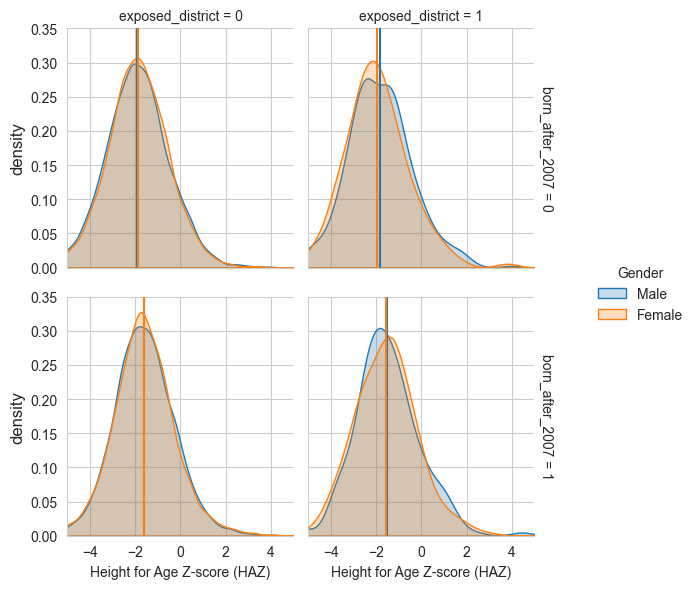

In [56]:
df_shp.columns = [n if n != "KIDSEX" else "Gender" for n in df_shp.columns]
df_shp.columns = [n if n != "exposed_distr_1" else "exposed_district" for n in df_shp.columns]
df_shp.columns = [n if n != "born_after" else "born_after_2007" for n in df_shp.columns]

g = sns.FacetGrid(df_shp, col="exposed_district", row="born_after_2007", hue="Gender", margin_titles=True,ylim=(0, 0.35), xlim=(-5, 5),sharex=True, sharey=True)
g.map(sns.kdeplot, "HWHAZWHO",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'HWHAZWHO')
#g5 = sns.displot(data=df, col='YEAR', hue='KIDSEX', x='HWWAZWHO', kind='kde', col_wrap=3,fill=True, facet_kws={'sharey': False, 'sharex': False})

# Add text to each plot for relevant popultion size
# NOTE - don't need to filter on ['Age'].isnull() for children, as 'is_child'=True only possible for children with 'Age' data
# for row in range(grid.axes.shape[0]):
#     grid.axes[row, 0].text(60.2, 0.052, 'Survived n = '+str(titanic_data.loc[titanic_data['Pclass']==row+1].loc[titanic_data['is_child_def']==False].loc[titanic_data['Age'].isnull()==False].loc[titanic_data['Survived']==1]['is_male'].sum()), size = 12)
#     grid.axes[row, 1].text(60.2, 0.052, 'Survived n = '+str(titanic_data.loc[titanic_data['Pclass']==row+1].loc[titanic_data['is_child_def']==False].loc[titanic_data['Age'].isnull()==False].loc[titanic_data['Survived']==1]['is_female'].sum()), size = 12)
#     grid.axes[row, 0].text(60.2, 0.047, 'Perished n = '+str(titanic_data.loc[titanic_data['Pclass']==row+1].loc[titanic_data['is_child_def']==False].loc[titanic_data['Age'].isnull()==False].loc[titanic_data['Survived']==0]['is_male'].sum()), size = 12)
#     grid.axes[row, 1].text(60.2, 0.047, 'Perished n = '+str(titanic_data.loc[titanic_data['Pclass']==row+1].loc[titanic_data['is_child_def']==False].loc[titanic_data['Age'].isnull()==False].loc[titanic_data['Survived']==0]['is_female'].sum()), size = 12)
#ax.set(xlabel='Height for Age Z-score (HAZ)', ylabel='common ylabel')
g.set_axis_labels("Height for Age Z-score (HAZ)")
g.set_ylabels('density', size=12)
#plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
#filename = 'Weight for Age Z-score density'
#plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)
filename="by_gender_distribution_haz_norm"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

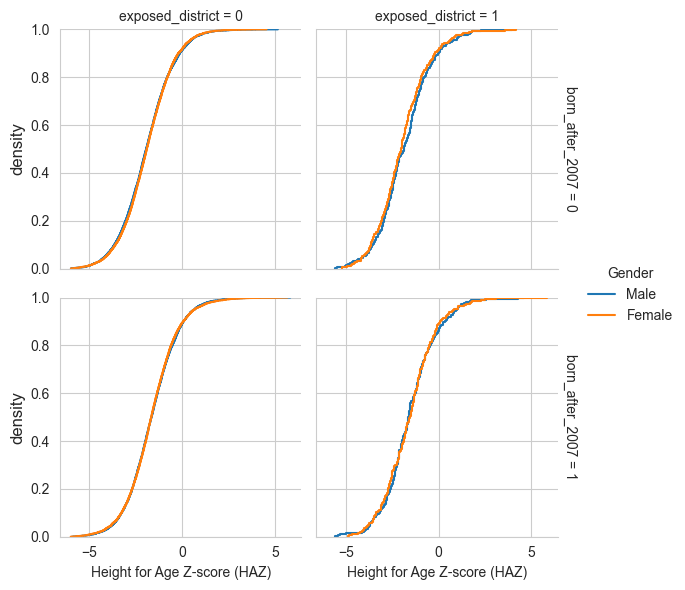

In [57]:
#cumulative

g = sns.FacetGrid(df_shp, col="exposed_district", row="born_after_2007", hue="Gender", margin_titles=True,sharex=True, sharey=True)
g.map(sns.ecdfplot, "HWHAZWHO",   stat='proportion')
g.add_legend()

#g.map(vertical_mean_line_survived, 'HWHAZWHO')

g.set_axis_labels("Height for Age Z-score (HAZ)")
g.set_ylabels('density', size=12)

filename="by_gender_distribution_haz_cum"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

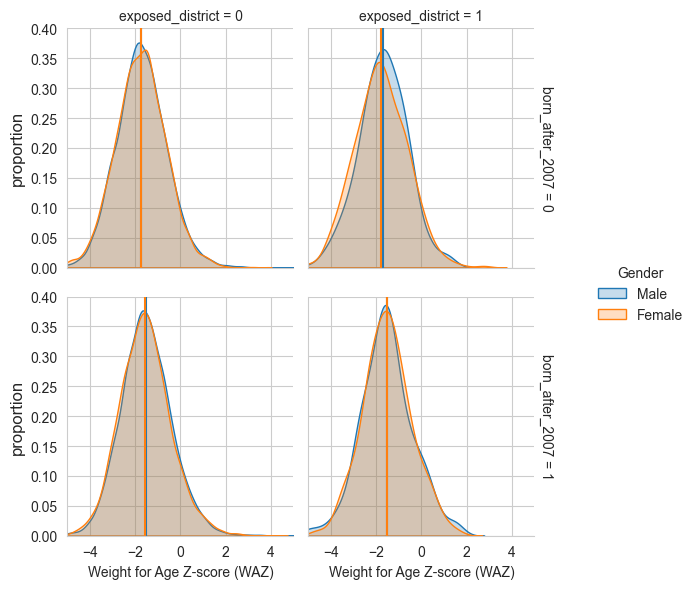

In [58]:
# df_interest.columns = [n if n != "KIDSEX" else "Gender" for n in df_interest.columns]
# df_interest.columns = [n if n != "exposed_distr_1" else "exposed_district" for n in df_interest.columns]
# df_interest.columns = [n if n != "born_after" else "born_after_2007" for n in df_interest.columns]

g = sns.FacetGrid(df_shp, col="exposed_district", row="born_after_2007", hue="Gender", margin_titles=True,ylim=(0, 0.4), xlim=(-5, 5),sharex=True, sharey=True)
g.map(sns.kdeplot, "HWWAZWHO",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'HWWAZWHO')

g.set_axis_labels("Weight for Age Z-score (WAZ)")
g.set_ylabels('proportion', size=12)

#g.axes[0,1].set_xlabel('axes label 1')

filename="by_gender_distribution_waz_interested"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

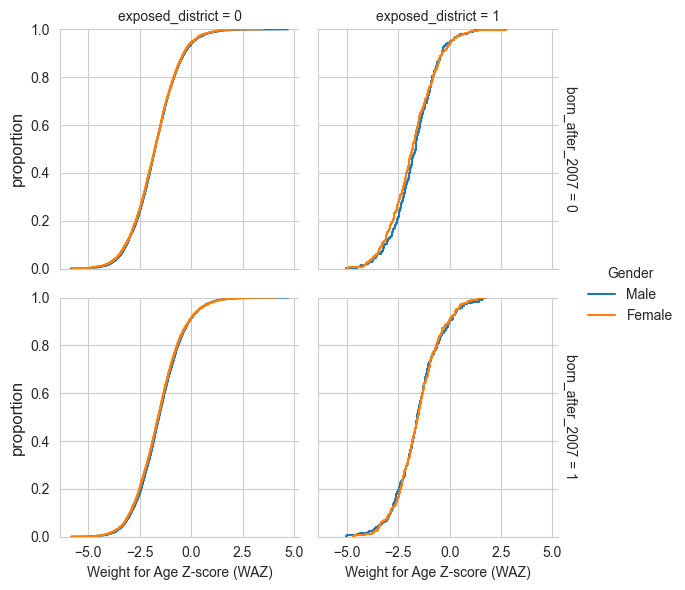

In [59]:
#cumulative

g = sns.FacetGrid(df_shp, col="exposed_district", row="born_after_2007", hue="Gender", margin_titles=True,sharex=True, sharey=True)
g.map(sns.ecdfplot, "HWWAZWHO",   stat='proportion')
g.add_legend()

#g.map(vertical_mean_line_survived, 'HWHAZWHO')

g.set_axis_labels("Weight for Age Z-score (WAZ)")
g.set_ylabels('proportion', size=12)

filename="by_gender_distribution_waz_cum"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

AttributeError: Line2D.set() got an unexpected keyword argument 'scheme'

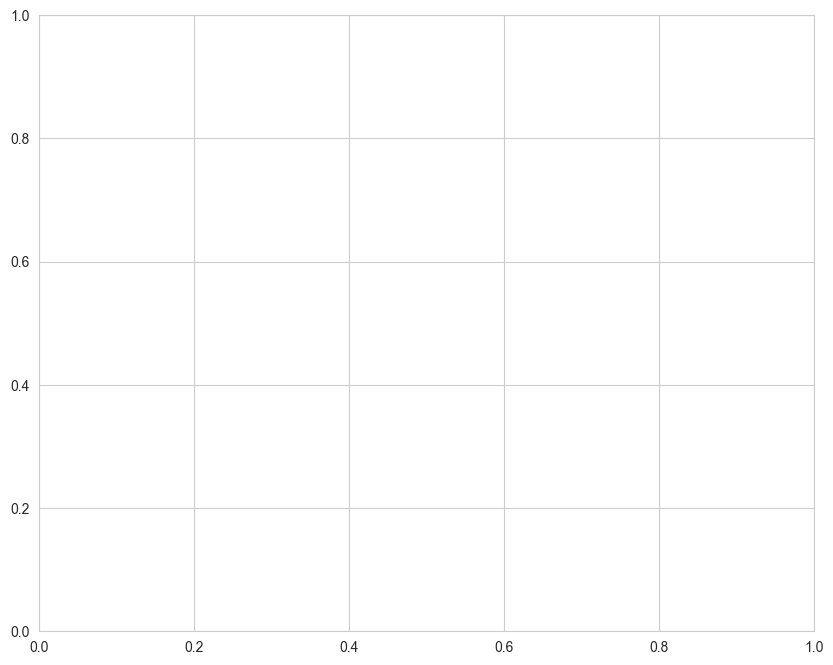

In [60]:

# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(1, figsize=(10,8))
cmap = 'Greys'
df_interest.plot(column="HWWAZWHO", scheme="quantiles", k=8, cmap=cmap, ax = ax, edgecolor='0.8', legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "interval": False})
ax.axis('off')
ax.set_title('Fully Damaged Households', fontdict={'fontsize': '15'})
# Create an annotation for the data source
ax.annotate('Source: London Datastore, 2014',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='#555555')


<Axes: xlabel='DHSID,geometry'>

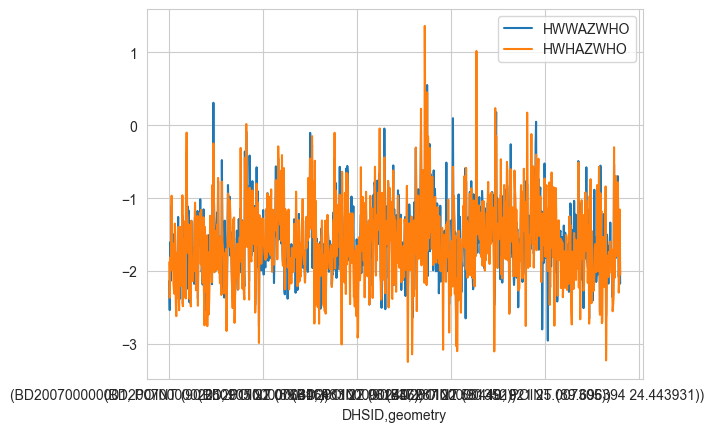

In [68]:
df_interest.groupby(['DHSID','geometry'])[['HWWAZWHO', 'HWHAZWHO']].mean().plot(column="HWWAZWHO")

In [152]:
df_interest = gpd.GeoDataFrame(df, geometry='geometry')

ValueError: Unknown column geometry

In [150]:
df_interest.columns

Index(['SAMPLE', 'SAMPLESTR', 'COUNTRY', 'YEAR', 'IDHSPID', 'IDHSHID', 'DHSID',
       'IDHSPSU', 'IDHSSTRATA', 'CASEID', 'HHID', 'PSU', 'STRATA', 'DOMAIN',
       'HHNUM', 'CLUSTERNO', 'LINENO', 'BIDX', 'PERWEIGHT', 'KIDWT', 'AWFACTT',
       'AWFACTU', 'AWFACTR', 'AWFACTE', 'AWFACTW', 'DVWEIGHT', 'URBAN',
       'GEO_BD1994_2014', 'GEO_BD1997', 'GEO_BD2000', 'GEO_BD2004',
       'GEO_BD2007', 'GEO_BD2011', 'GEO_BD2014', 'AGE', 'AGE5YEAR', 'RESIDENT',
       'RELIGION', 'MARSTAT', 'CHEB', 'CURRWORK', 'WEALTHQ', 'WEALTHS',
       'EDUCLVL', 'EDYRTOTAL', 'Gender', 'LINENOKID', 'KIDAGEMO', 'HWWEIGHT',
       'HWHEIGHT', 'HWWHYNOTMEAS', 'HWDAYOFBIRTH', 'HWHAZWHO', 'HWWAZWHO',
       'HWWHZWHO', 'HWBMIZWHO', 'born_after_2007', 'Unnamed: 0', 'DHSCC',
       'DHSYEAR', 'DHSCLUST', 'CCFIPS', 'ADM1FIPS', 'ADM1FIPSNA', 'ADM1SALBNA',
       'ADM1SALBCO', 'ADM1DHS', 'ADM1NAME', 'DHSREGCO', 'DHSREGNA', 'SOURCE',
       'URBAN_RURA', 'LATNUM', 'LONGNUM', 'ALT_GPS', 'ALT_DEM', 'DATUM',
       'geome

In [ ]:
pd.crosstab(df_shp.born_after, [df_shp.exposed_distr_1, df_shp.KIDSEX], values=df_shp.HWWAZWHO, aggfunc='mean')

#### Using data for Ministry of Food and Disaster Management